# Welding Example #01: Basics
The goal of this small examples is to introduce the main functionalities and interfaces to create and describe a simple welding application using the WelDX package.

## Imports

In [ ]:
# if the package is not installed in your python environment, run this to execute the notebook directly from inside the GitHub repository
%cd -q ..

In [ ]:
# enable interactive plots on Jupyterlab with ipympl and jupyterlab-matplotlib installed
# %matplotlib widget

In [3]:
# some python imports that will be used throughout the tutorial
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pint
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# importing the weldx package with prevalent default abbreviations
import weldx
import weldx.geometry as geo
import weldx.transformations as tf
import weldx.utility as ut
import weldx.visualization as vis
from weldx import Q_
from weldx.transformations import LocalCoordinateSystem as lcs
from weldx.transformations import WXRotation

## create a simple welding groove shape
We start of defining our welding application example by defining the base groove shape. For this examples we assume the groove shape to be constant along the entire workpiece.

The groove shall have the following attributes:
- a workpiece thickness of 0.5 cm
- a single sided V-Groove butt weld with 50 degree groove angle
- root gap and face of 1 mm

To generate the groove shape, we can use the `get_groove` function of the of `iso_groove` that implements all groove types and shapes defined in *ISO 9692-1:2013*. For all available groove types and options take a look at the extensive docstring of `get_groove` and the groove_type tutorial notebook.

Be aware that we must pass along all groove parameters as Quantities with a specified unit using the default `Q_` type imported above. All units are automatically converted to SI units for most mathematical operations in the background so we can specify parameters in any appropriate unit we desire.

In [5]:
from weldx.asdf.tags.weldx.core.iso_groove import get_groove

groove = get_groove(
    groove_type="VGroove",
    workpiece_thickness=Q_(0.5, "cm"),
    groove_angle=Q_(50, "deg"),
    root_face=Q_(1, "mm"),
    root_gap=Q_(1, "mm"),
)

Using the `plot` function of the created groove instance gives a quick overview of the created geometry.

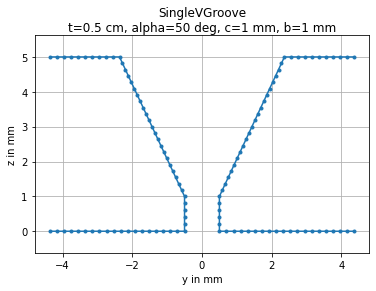

In [6]:
groove.plot(raster_width=0.2)

## create 3d workpiece geometry
Once we have created our desired 2d groove shape, we can simply extend the groove shape into 3d-space to create a volumetric workpiece.

To do this, two steps are missing:
1. we have to decide on a weld seam length first (we will use 300 mm in this example)
2. create a trace object that defines the path of our element though space. (we use a simple linear trace in this example)

In [7]:
# define the weld seam length in mm
seam_length = 300

# create a linear trace segment a the complete weld seam trace
trace_segment = geo.LinearHorizontalTraceSegment(seam_length)
trace = geo.Trace(trace_segment)

Once we have defined the trace object, we can create the workpiece geometry by combining the groove profile with the trace.

In [8]:
# create 3d workpiece geometry from the groove profile and trace objects
geometry = geo.Geometry(groove.to_profile(width_default=Q_(4, "mm")), trace)

To visualize the geometry we rasterize each profile along specific steps of the trace.

In [9]:
# rasterize geometry
profile_raster_width = 0.5  # resolution of each profile in mm
trace_raster_width = 15  # space between profiles in mm
geometry_data_sp = geometry.rasterize(
    profile_raster_width=profile_raster_width, trace_raster_width=trace_raster_width
)

Simple scatter plot of the geometry

In [10]:
def ax_setup(ax):
    ax.legend()
    ax.set_xlabel("x / mm")
    ax.set_ylabel("y / mm")
    ax.set_zlabel("z / mm")

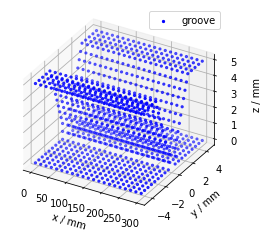

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", proj_type="ortho")
ax.scatter(
    geometry_data_sp[0, :],
    geometry_data_sp[1, :],
    geometry_data_sp[2, :],
    marker=".",
    c="b",
    label="groove",
)
ax_setup(ax)

## Setup the Coordinate System Manager
Once we have created the 3d geometry it is now time to describe the movement of the wire during the welding process. To handle different moving coordinate systems and objects we use the CoordinateSystemManager (CSM).

Start by creating a new instance of the CSM. When setting up a CSM instance we have to supply a name that indicates the reference coordinate system which is a static Cartesian coordinate system that defines an origin.

In [12]:
# crete a new coordinate system manager with default base coordinate system
csm = weldx.transformations.CoordinateSystemManager("base")

The trace we created earlier to extend the groove shape into 3d has its own associated coordinate system that starts in the origin of the groove (see point (0,0) in our first plot of the groove profile) and has the x-axis running along the direction of the weld seam by convention.

We simply add the trace coordinate system to our coordinate system manager defining at as the *workpiece* coordinate system.

In [13]:
# add the workpiece coordinate system
csm.add_cs(coordinate_system_name="workpiece", reference_system_name="base", local_coordinate_system=trace.coordinate_system)

## generate the tcp movement of the wire tip

For this example, we want the tip of the wire (i.e. the robot TCP during welding) to move along the center of the groove at 2 mm from the bottom of the workpiece with a speed of 10 mm/s.

We begin by defining the start and end points relative to our workpiece coordinate system. Note that the z-axis of the workpiece coordinate system is pointing upwards (see Figure 1). Hence we use a positive offset of 2 mm in z direction from our workpiece. For the x-axis we start the weld 5 mm into the weldseam and 5 mm before reaching the end of the weldseam.

In [14]:
tcp_start_point = Q_([5.0, 0.0, 2.0], "mm")
tcp_end_point = Q_([seam_length - 5.0, 0.0, 2.0], "mm")

To completely describe the TCP movement in space __and__ time we need to supply time information for the start and end point. Lets say the weld starts on 2020-04-20 10:00:00. We calculate the time

In [15]:
v_weld = Q_(10, "mm/s")
s_weld = (tcp_end_point - tcp_start_point)[0]  # length of the weld
t_weld = s_weld / v_weld

t_start = pd.Timedelta("0s")
t_end = pd.Timedelta(str(t_weld))

The two points and timestamps are enough to create the linear moving coordinate system. We can interpolate the movement with a higher resolution later.

The orientation of the wire has the z coordinate facing downwards towards the workpiece. The workpiece z-coordinate is facing upwards. We add a constant 180 degree rotation around the x-axis to orientate the wire coordinate system correctly. Orientations can be described using the scipy Rotation objects

In [16]:
rot = WXRotation.from_euler(seq="x", angles=180, degrees=True)

With the defined coordinates, the constant orientation and the associated times we can create the coordinate system for the wire tcp.

In [17]:
coords = [tcp_start_point.magnitude, tcp_end_point.magnitude]

tcp_wire = lcs(
    coordinates=coords, orientation=rot, time=[t_start, t_end]
)

Add the new coordinate system to the coordinate system manager relative to the workpiece.

In [18]:
# add the workpiece coordinate system
csm.add_cs(coordinate_system_name="tcp_wire", reference_system_name="workpiece", local_coordinate_system=tcp_wire)

Lets say The wire extends 10 mm from the contact tip. We can add the contact tip as another point using the coordinate system manager. To simplify things we now use the _tcp_wire_ coordinate system as reference. All we need to add is the z-offset along the wire. Note that we have to provide a negative offset along the z-axis since the _wire-tcp_ z-axis is pointing downwards.

In [19]:
tcp_contact = lcs(coordinates=[0, 0, -10])

In [20]:
# add the workpiece coordinate system
csm.add_cs(coordinate_system_name="tcp_contact", reference_system_name="tcp_wire", local_coordinate_system=tcp_contact)

We can create a simple plot of the relations between our our coordinate systems

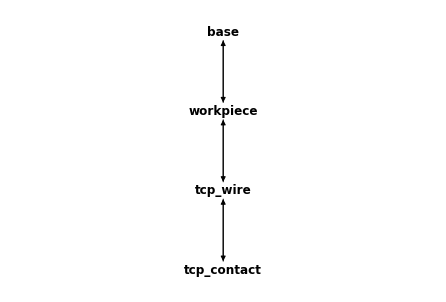

In [21]:
csm

## plot the TCP trajectory
To examine the movement of our wire TCP and contact tip, lets create a simple plot. We only have a linear movement we don't have to add additional timestamps to the moving coordinate systems.

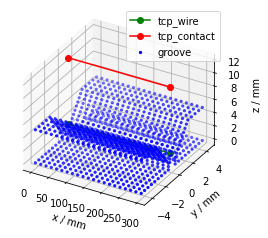

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d", proj_type="ortho")
ax.scatter(
    geometry_data_sp[0, :],
    geometry_data_sp[1, :],
    geometry_data_sp[2, :],
    marker=".",
    c="b",
    label="groove",
)

cs = csm.get_local_coordinate_system("tcp_wire", "workpiece")
data = cs.coordinates.data
ax.plot(data[:, 0], data[:, 1], data[:, 2], label="tcp_wire", c="g", marker="o")

cs = csm.get_local_coordinate_system("tcp_contact", "workpiece")
data = cs.coordinates.data
ax.plot(data[:, 0], data[:, 1], data[:, 2], label="tcp_contact", c="r", marker="o")

ax_setup(ax)

## Add static temperature measurement points
With everything setup we can now start adding some measurements with associated points in space. We add a temperature measurements __T1, T2, T3__ to the surface of the weld seam.

In [23]:
# add the workpiece coordinate system
csm.add_cs("T1", "workpiece", lcs(coordinates=[100, 4, 5]))
csm.add_cs("T2", "workpiece", lcs(coordinates=[150, 4, 5]))
csm.add_cs("T3", "workpiece", lcs(coordinates=[200, 4, 5]))

In [24]:
for T in ["T1", "T2", "T3"]:
    cs = csm.get_local_coordinate_system(T, "workpiece")
    data = cs.coordinates.data
    ax.scatter(data[0], data[1], data[2], label=T, c="orange", marker="o")
ax.legend()

## Add current and voltage measurements at the contact tip

## Add power source settings